# **Sentiment Analysis - Donald Trump 2024 Election**

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ8MafJxn7aKgP_qQ8g8xwjulHcH94lzgTbXw&s"  width="600" height="305">

## *by Martin Segovia*

### This project aims to conduct sentiment analysis on YouTube videos related to the "Donald Trump Election 2024" topic. The analysis will initially focus on quantitative metrics such as likes count, views count, comments count, and dislikes count to analyze the overall engagement and reception of these videos. After that, applying sentiment analysis techniques will dive deeper into the emotions expressed within the comments section of these videos.

# **PART 1 - Getting the data**

### I make use of the Youtube API V3 to access the videos information.
### First, I import the necessary libraries for the project.

In [120]:
!pip install unidecode

In [121]:
!pip install langdetect

In [122]:
pip install --upgrade google-api-python-client

In [123]:
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
import unidecode
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### For the analysis, I require to download 2 types of information:
* ### Descriptive data about the videos: "title", "videoId", "viewCount", "likeCount", "commentCount", "duration", "tags", "channel_name", "subscriber_count"
* ### The text corresponding to each comment of the videos

### Based on this, I create 2 functions: `youtube_descriptive_search`, and `get_video_comments`. I also create a function to express the video duration in minutes (`convert_duration`).

In [124]:
################################################################################
############################### convert_duration ###############################
################################################################################
def convert_duration(duration_str):
    """The Youtube API gets the duration in the format PT1H1M1S. This function converts the duration into minutes."""
    # Using regular expression to find the hours, minutes, and seconds
    match = re.match(r'PT(\d+H)?(\d+M)?(\d+S)?', duration_str)
    if match:
        hours = int(match.group(1)[:-1]) if match.group(1) else 0
        minutes = int(match.group(2)[:-1]) if match.group(2) else 0
        seconds = int(match.group(3)[:-1]) if match.group(3) else 0
        total_minutes = hours * 60 + minutes + round(seconds / 60)
        return total_minutes
    else:
        return None


################################################################################
########################## youtube_descriptive_search ##########################
################################################################################
def youtube_descriptive_search(search_query, max_results):
    # Construct a Resource for interacting with the YouTube API.
    youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION, developerKey=DEVELOPER_KEY)

    # Call the search.list method to retrieve results matching the specified query
    videos = []
    next_page_token = None

    # The number of videos per request is 50. So we make a loop in order to get more results
    while len(videos) < max_results:
        search_response = youtube.search().list(
            q=search_query,
            part="id,snippet",
            maxResults=min(max_results - len(videos), 50),
            pageToken=next_page_token
        ).execute()

        # Add each result to the videos list
        for search_result in search_response.get("items", []):
            if search_result["id"]["kind"] == "youtube#video":
                videos.append(search_result)

        # Check if there are more pages of results
        next_page_token = search_response.get("nextPageToken")
        if not next_page_token:
            break

    # Create a CSV output for video list
    with open('video_descriptive_result.csv', 'w', newline='', encoding='utf-8') as csvFile:
        csvWriter = csv.writer(csvFile)
        csvWriter.writerow(["title", "videoId", "viewCount", "likeCount", "commentCount", "duration", "tags", "channel_name", "subscriber_count"])

        # Add each result to the CSV file
        for search_result in videos:

              title = unidecode.unidecode(search_result["snippet"]["title"])
              videoId = search_result["id"]["videoId"]
              video_response = youtube.videos().list(id=videoId, part="statistics,contentDetails,snippet").execute()
              for video_result in video_response.get("items", []):
                  viewCount = video_result["statistics"].get("viewCount", 0)
                  likeCount = video_result["statistics"].get("likeCount", 0)
                  commentCount = video_result["statistics"].get("commentCount", 0)
                  duration = video_result["contentDetails"]["duration"]
                  tags = video_result["snippet"]["tags"] if "tags" in video_result["snippet"] else []
                  channel_id = video_result["snippet"]["channelId"]
                  channel_response = youtube.channels().list(id=channel_id, part="snippet,statistics").execute()
                  channel_info = channel_response.get("items", [])[0]["snippet"]
                  channel_name = unidecode.unidecode(channel_info["title"])
                  subscriber_count = channel_response.get("items", [])[0]["statistics"].get("subscriberCount", 0)

              duration = convert_duration(duration)

              # Write video details to CSV
              csvWriter.writerow([title, videoId, viewCount, likeCount, commentCount, duration, ','.join(tags), channel_name, subscriber_count])

    print("CSV file has been created successfully.")


################################################################################
############################## get_video_comments ##############################
################################################################################
def get_video_comments(video_id):
    youtube = build("youtube", "v3", developerKey=DEVELOPER_KEY)
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100
    )

    # Handdling the http forbiden error. If the request returns a 403 error, then the function returns None.
    try:
        response = request.execute()
    except HttpError as e:
        if e.resp.status == 403:
            print(f"Comments are disabled for video {video_id}")
            return None
        else:
            raise e

    comments = []

    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        comments.append([
            comment['authorDisplayName'],
            comment['textDisplay']
        ])

    return pd.DataFrame(comments, columns=['author', 'text'])


### Now I apply the functions and get the data. I create 2 dataframes, `df_descrip` and `df_comments`

In [125]:
# First, I set up the YouTube API key
DEVELOPER_KEY = "***"
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"

# I define the query I want to search
search_query = "Donald Trump election 2024"


##################################################################
#################### DESCRIPTIVE DATA ############################
##################################################################

# I get the descriptive data and store it in df_descrip dataframe
youtube_descriptive_search(search_query,max_results=500)

df_descrip = pd.read_csv('video_descriptive_result.csv')

##################################################################
####################### COMMENTS DATA ############################
##################################################################
# I take the list of video IDs to pass to the get_video_comments function
video_ids = list(df_descrip['videoId'])

# Create an empty DataFrame to store the comments from all the videos
all_comments_df = pd.DataFrame(columns=['video_id', 'author', 'text'])

# Iterate over each video ID, download comments, and append to the all_comments_df dataframe
for video_id in video_ids:
    video_comments_df = get_video_comments(video_id)
    if video_comments_df is not None:
        video_comments_df['video_id'] = video_id  # Add a column for video ID
        all_comments_df = pd.concat([all_comments_df, video_comments_df], ignore_index=True)
    else:
        print(f"Skipping video {video_id} due to disabled comments.")

CSV file has been created successfully.


Comments are disabled for video thit--jp4fc
Skipping video thit--jp4fc due to disabled comments.


Comments are disabled for video GhyG4VhYGKw
Skipping video GhyG4VhYGKw due to disabled comments.


Comments are disabled for video YgM21BA61JI
Skipping video YgM21BA61JI due to disabled comments.


Comments are disabled for video mFA08fHjXRc
Skipping video mFA08fHjXRc due to disabled comments.


Comments are disabled for video bND3d-QyTjM
Skipping video bND3d-QyTjM due to disabled comments.


Comments are disabled for video mFA08fHjXRc
Skipping video mFA08fHjXRc due to disabled comments.


Comments are disabled for video mFA08fHjXRc
Skipping video mFA08fHjXRc due to disabled comments.


Comments are disabled for video GhyG4VhYGKw
Skipping video GhyG4VhYGKw due to disabled comments.


Comments are disabled for video cP8DTjEYQ3M
Skipping video cP8DTjEYQ3M due to disabled comments.


Comments are disabled for video enJwnRjkE9g
Skipping video enJwnRjkE9g due to disabled comments.


Comments are disabled for video TztxwKfud-k
Skipping video TztxwKfud-k due to disabled comments.


Comments are disabled for video -T7f8VREm2U
Skipping video -T7f8VREm2U due to disabled comments.


Comments are disabled for video gi5j_oIOVAY
Skipping video gi5j_oIOVAY due to disabled comments.


Comments are disabled for video xx-eIH-hC0s
Skipping video xx-eIH-hC0s due to disabled comments.


Comments are disabled for video QPFoa6T4D78
Skipping video QPFoa6T4D78 due to disabled comments.


Comments are disabled for video SBtEW2XmEEU
Skipping video SBtEW2XmEEU due to disabled comments.


Comments are disabled for video vSD4cMhISfc
Skipping video vSD4cMhISfc due to disabled comments.


Comments are disabled for video eZHD3PbbTqw
Skipping video eZHD3PbbTqw due to disabled comments.


Comments are disabled for video 2TxWeuVtOAw
Skipping video 2TxWeuVtOAw due to disabled comments.


Comments are disabled for video Hwei5ALNJyQ
Skipping video Hwei5ALNJyQ due to disabled comments.


Comments are disabled for video AcJV1ohOhak
Skipping video AcJV1ohOhak due to disabled comments.


Comments are disabled for video bU4JKV9Opt0
Skipping video bU4JKV9Opt0 due to disabled comments.


Comments are disabled for video 7xY5GznBWQg
Skipping video 7xY5GznBWQg due to disabled comments.


Comments are disabled for video fAq6vFKOcXc
Skipping video fAq6vFKOcXc due to disabled comments.


Comments are disabled for video _TSoF0VlXTg
Skipping video _TSoF0VlXTg due to disabled comments.
Comments are disabled for video _TSoF0VlXTg
Skipping video _TSoF0VlXTg due to disabled comments.


Comments are disabled for video J7hEGwytxk0
Skipping video J7hEGwytxk0 due to disabled comments.


Comments are disabled for video _zT5Q2Yd1kE
Skipping video _zT5Q2Yd1kE due to disabled comments.


Comments are disabled for video S9d28cT8mng
Skipping video S9d28cT8mng due to disabled comments.


In [126]:
df_descrip.head()

,title,videoId,viewCount,likeCount,commentCount,duration,tags,channel_name,subscriber_count
0,Donald Trump announces 2024 presidential campaign,TjybYG8BBK0,111210,1859,1032,2,"2024,Donald,Trump,announces,campaign,p_cmsid=2...",ABC News,16500000
1,Is Trump the frontrunner in the general electi...,fQSL6FtaJBo,103800,1860,1098,6,"Joe Scarborough,Willie Geist,Morning Joe,Mika ...",MSNBC,6680000
2,Ex-Britain PM urges that Trump has to win 2024...,tIiz2pVZbV0,143389,4256,928,4,"fox news,fox news live,fox news today,fox news...",Fox Business,2450000
3,US Election 2024: The Trump v Biden rematch i...,s9P3hgZ6YZs,99613,914,645,3,"bbc,bbc news,news,world news,breaking news,us ...",BBC News,15900000
4,Full Panel: Trump could win 2024 election 'by ...,eaK6n8YaA_Q,110509,878,792,8,"dc,election,government,meet the press,mtp,poli...",NBC News,9920000


In [127]:
all_comments_df.head()

,video_id,author,text
0,TjybYG8BBK0,@wolfnite59,i never voted at all as that am older as...
1,TjybYG8BBK0,@juanitavillarreal9929,"Cheap food, gas???? And/or no more freedom."
2,TjybYG8BBK0,@garyseats1729,No president shall own any stocks or bonds or ...
3,TjybYG8BBK0,@IshaBhardwaj-gn6sv,&quot;I&#39;m deeply concerned about the impac...
4,TjybYG8BBK0,@eschmidtiii4673,He didn’t deliver on most of his promises in 2...


In [128]:
df_descrip.shape

(500, 9)

In [129]:
all_comments_df.shape

(39566, 3)

# **PART 2 - Social Media Data Analysis**

## **Relationship between numerical variables**

In [130]:
# First, I select the numerical columns
columns = ["viewCount", "likeCount", "commentCount", "duration","subscriber_count"]

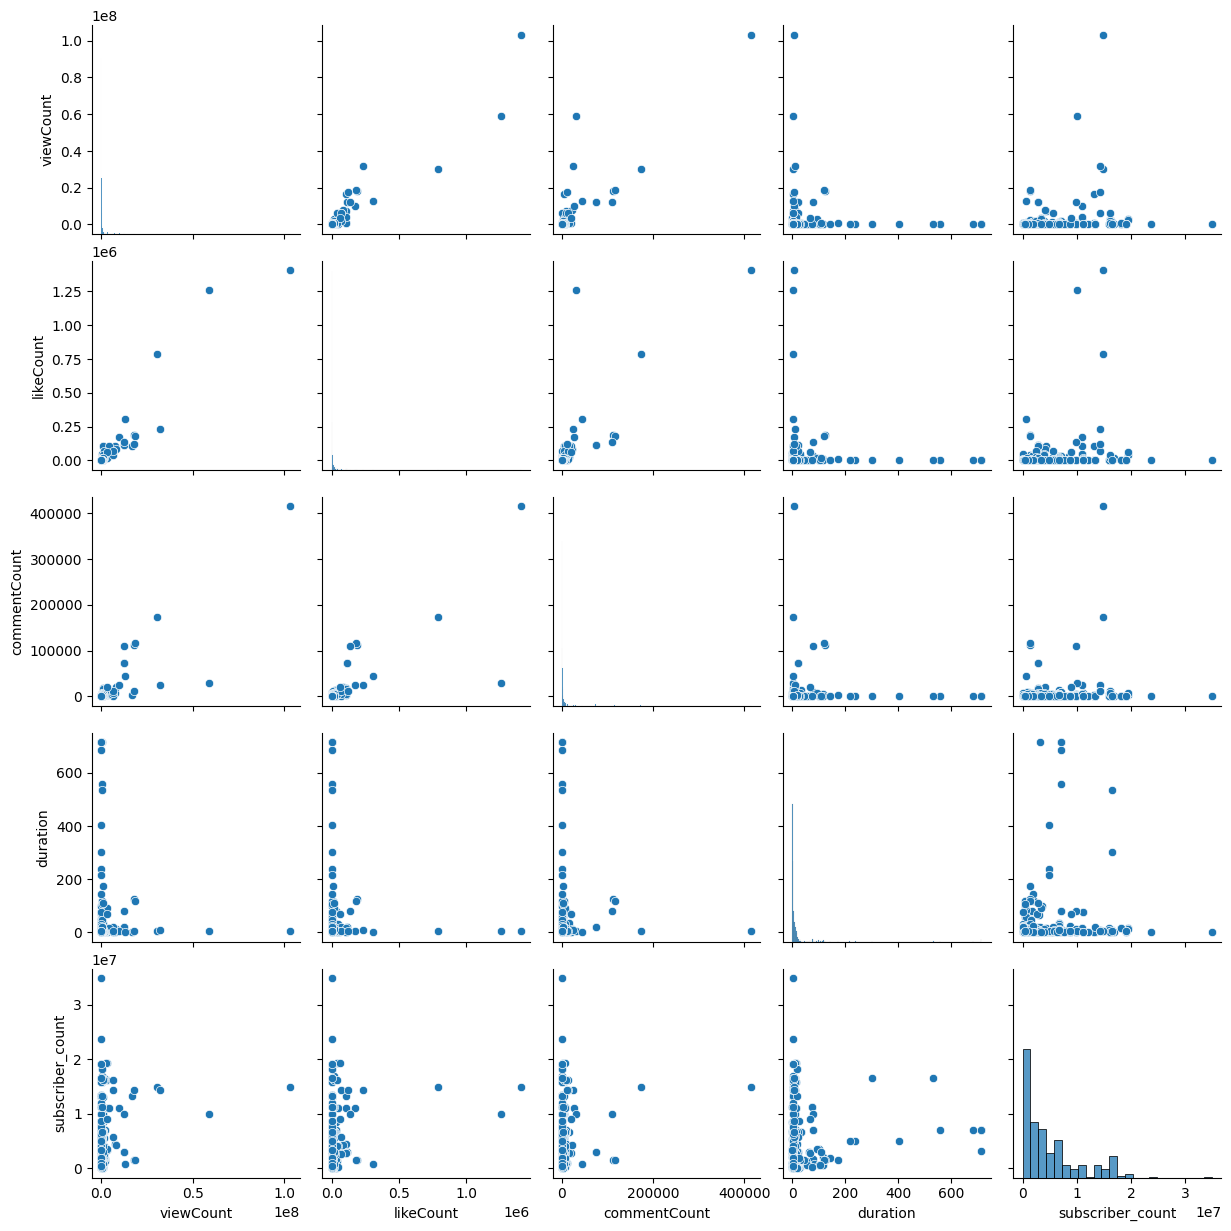

In [131]:
sns.pairplot(df_descrip[columns])

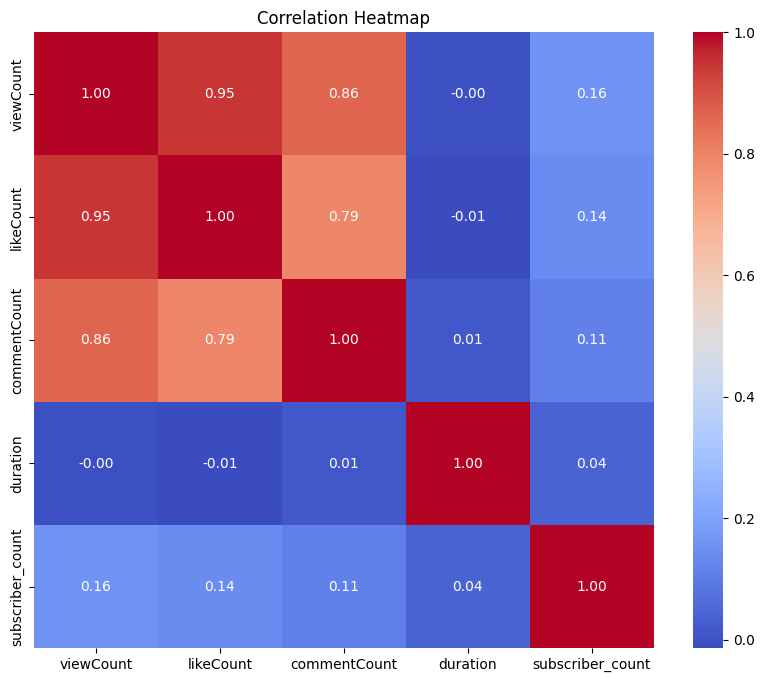

In [132]:
# Now, I calculate the correlation matrix
correlation_matrix = df_descrip[columns].corr()

# Create the heatmap based on the correlation matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Display the plot
plt.title("Correlation Heatmap")
plt.show()


### This is what I can observe in terms of linear correlations:
* ### The strong positive correlation between viewCount and likeCount (0.95) indicates that videos with more views tend to have more likes, suggesting that viewer engagement increases with the number of views.
* ### The strong positive correlation between viewCount and commentCount (0.86) suggests that videos with higher view counts tend to attract more comments.
* ### The length of a video (duration) has minimal impact on its view count.
* ### The weak positive correlation between viewCount and subscriber_count (0.16) suggests a slight association between a channel's subscriber count and the view count of its videos, indicating that channels with more subscribers may tend to have higher view counts, but the linear relationship is not strong.
* ### The weak positive correlation between likeCount and subscriber_count (0.14) suggests a slight association between a channel's subscriber count and the number of likes its videos receive, indicating that channels with more subscribers may tend to receive more likes, but again, the relationship is not strong.

## **Linear model: Likes explained by View count**

### Based on the correlations found above, I build a least square regression model to see if the views count can predict the number of likes in the videos.

### In this section I use the following relevant functions:
* ### `X.values.flatten()`: it converts the DataFrame X into a one-dimensional array, which can be useful for plotting or performing calculations that expect one-dimensional data.
* ### `LinearRegression()`: This function creates an instance of the linear regression model from scikit-learn's linear_model module.
* ### `.fit()`: This method is used to train the linear regression model. It takes input data (independent variables) and target data (dependent variable) as arguments and adjusts the parameters of the model to best fit the provided data. After calling .fit(), the model is trained and ready to make predictions.
* ### `.predict()`: This method is used to make predictions using the trained linear regression model.
* ### `r2_score()`: This function computes the R-squared coefficient, also known as the coefficient of determination.

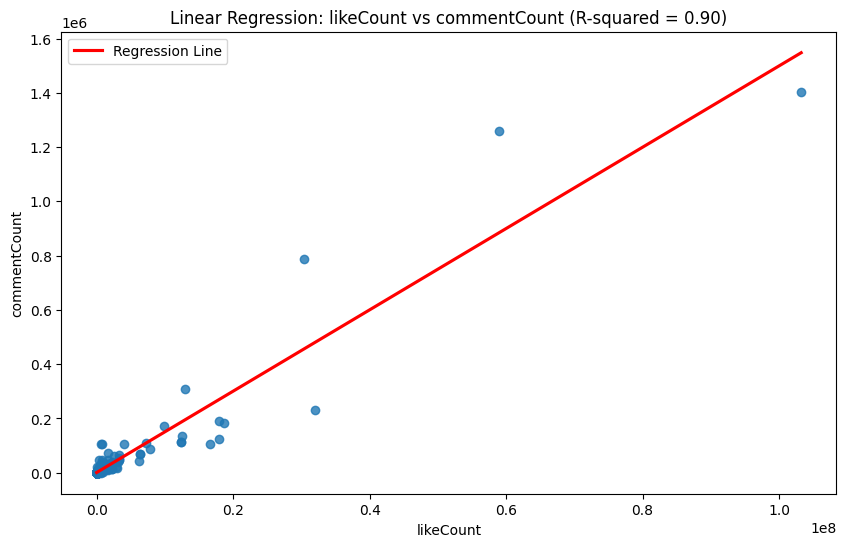

In [133]:
# Defining the independent (X) and dependent (y) variables
X = df_descrip[['viewCount']]
y = df_descrip['likeCount']

# fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate R-squared coefficient
r_squared = r2_score(y, y_pred)

# Plot the regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=X.values.flatten(), y=y, ci=None, line_kws={'color': 'red', 'label': 'Regression Line'})
plt.title(f'Linear Regression: likeCount vs commentCount (R-squared = {r_squared:.2f})')
plt.xlabel('likeCount')
plt.ylabel('commentCount')
plt.legend()
plt.show()


In [134]:
print(f'This is the equation of the linear model:\n\ny = {round(model.intercept_,4)} + {round(model.coef_[0],4)} * X')

This is the equation of the linear model:

y = 783.9451 + 0.015 * X


### The R-squared value of **0.90** indicates that approximately 90% of the variability in the `likeCount` can be explained by the variability in the `viewCount` using the linear regression model. This suggests that there is a strong linear relationship between the number of views and the number of likes.
### The high R-squared value supports the assumption that the relationship between viewCount and likeCount is linear. This means that as the number of views increases, we can expect the number of likes to increase proportionally.

## **Analysis by Channel**

### Top 10 Channels by Subscribers

<ipython-input-135-f680cb05c3be>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_subscribers_millions.index, y=top_10_subscribers_millions.values, palette='viridis')


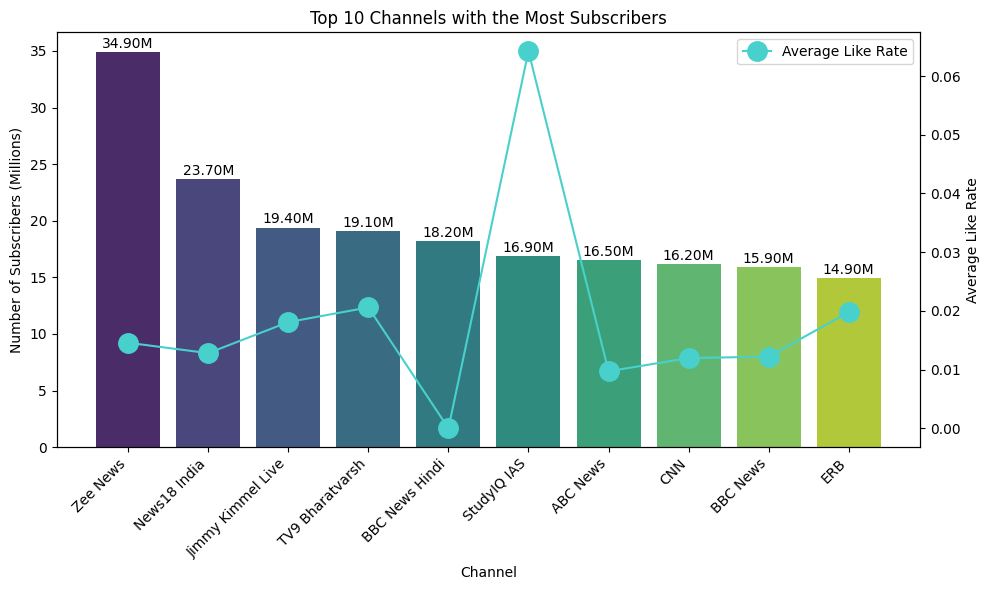

In [135]:
# First I create the variable like_rate
df_descrip['like_rate'] = df_descrip['likeCount'] / df_descrip['viewCount']

# Group the df_descrip DataFrame by channel and get the maximum subscriber count
channel_subscribers = df_descrip.groupby('channel_name')['subscriber_count'].max().sort_values(ascending=False)

# Select the top 10 channels with the most subscribers
top_10_subscribers = channel_subscribers.head(10)

# Convert subscribers to millions
top_10_subscribers_millions = top_10_subscribers / 1_000_000

# Create the plot for the top 10 channels
plt.figure(figsize=(10, 6))

# Plot the bar plot for subscribers
sns.barplot(x=top_10_subscribers_millions.index, y=top_10_subscribers_millions.values, palette='viridis')
plt.title('Top 10 Channels with the Most Subscribers')
plt.xlabel('Channel')
plt.ylabel('Number of Subscribers (Millions)')
plt.xticks(rotation=45, ha='right')

# Add labels to each bar
for i, v in enumerate(top_10_subscribers_millions.values):
    plt.text(i, v + 0.1, f'{v:.2f}M', ha='center', va='bottom')

# Add the average like rate for each channel as a line with markers
average_like_rate = df_descrip.groupby('channel_name')['like_rate'].mean().reindex(top_10_subscribers.index)
plt.twinx()
plt.plot(average_like_rate.index, average_like_rate.values, marker='o', color='mediumturquoise', label='Average Like Rate', markersize=14)
plt.ylabel('Average Like Rate')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Zee News has the highest number of subscribers among the listed channels, with 34.9 million subscribers, followed by News18 India (23.7 million), and Jimmy Kimmel Live (19.4 million).
### Related to the like rate, StudyIQ IAS has the highest average like rate among the listed channels. It shows a value of 6.4%, indicating that a relatively high proportion of viewers like the videos from this channel. TV9 Bharatvarsh follows with an average like rate of 2.1%, indicating a significant level of viewer engagement.

### Top 10 channels by views and likes

<ipython-input-136-f9cbaa5d48e3>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_views.values, y=top_10_views.index, ax=axes[0], palette='viridis')
<ipython-input-136-f9cbaa5d48e3>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_likes.values, y=top_10_likes.index, ax=axes[1], palette='viridis')


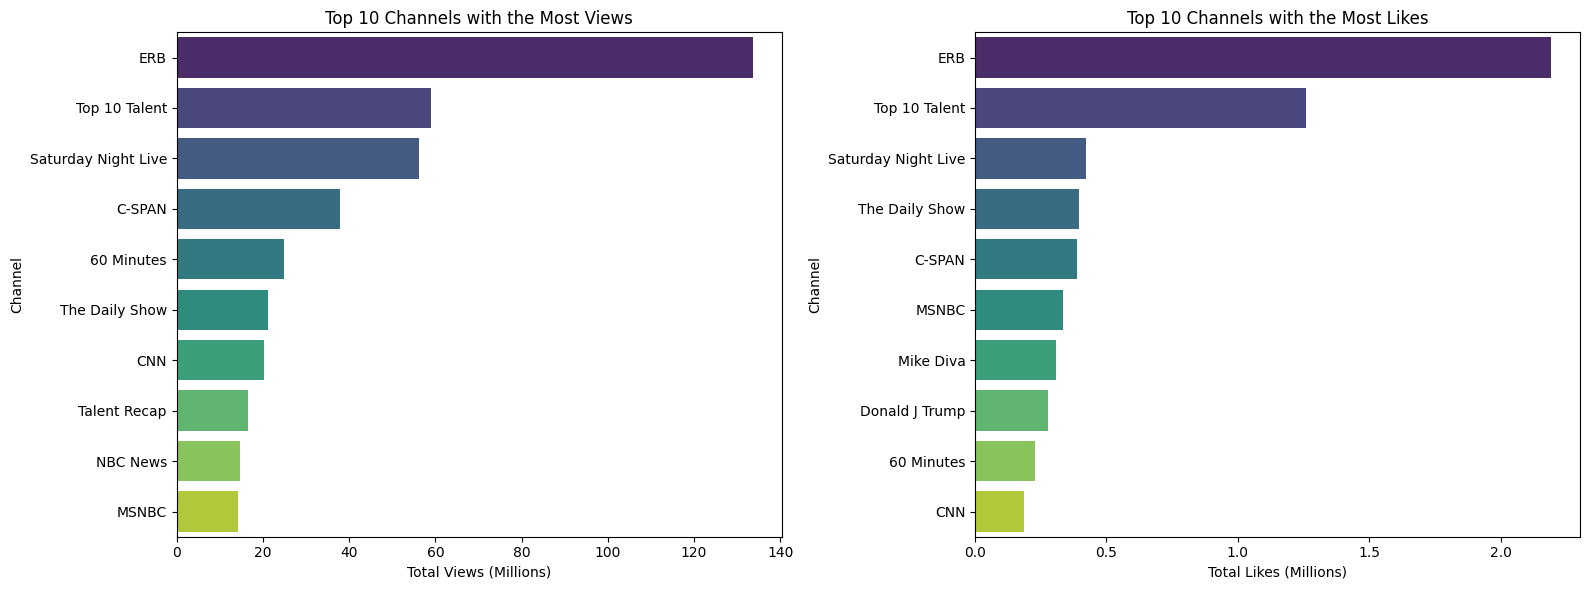

In [136]:
# Group the data by channel and sum the views and likes
channel_views = df_descrip.groupby('channel_name')['viewCount'].sum().sort_values(ascending=False)
channel_likes = df_descrip.groupby('channel_name')['likeCount'].sum().sort_values(ascending=False)

# Convert views and likes to millions
channel_views_millions = channel_views / 1_000_000
channel_likes_millions = channel_likes / 1_000_000

# Select the top 10 channels with the most views and likes
top_10_views = channel_views_millions.head(10)
top_10_likes = channel_likes_millions.head(10)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Bar plot for views
sns.barplot(x=top_10_views.values, y=top_10_views.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top 10 Channels with the Most Views')
axes[0].set_xlabel('Total Views (Millions)')
axes[0].set_ylabel('Channel')

# Bar plot for likes
sns.barplot(x=top_10_likes.values, y=top_10_likes.index, ax=axes[1], palette='viridis')
axes[1].set_title('Top 10 Channels with the Most Likes')
axes[1].set_xlabel('Total Likes (Millions)')
axes[1].set_ylabel('Channel')

plt.tight_layout()
plt.show()


 ### Considering `'Donald Trump election 2024'` topic, the ERB channel maintains its position as a popular choice among viewers, not only in terms of views but also in terms of likes received. Top 10 Talent, Saturday Night Live, and C-SPAN also demonstrate strong engagement levels, reflecting the diverse preferences and interests of audiences on the platform.

### Tags Overview

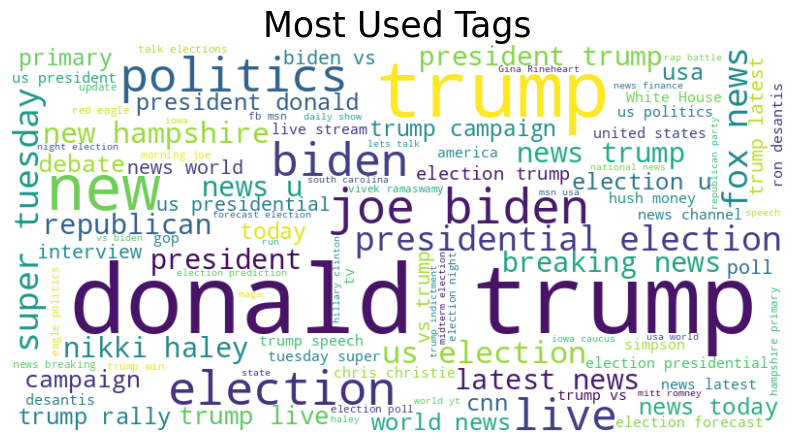

In [137]:
# Build a word cloud using the tags of each video.

# First I need to combine all tags into a single string, excluding NaN values
all_tags = ' '.join(df_descrip['tags'].dropna().astype(str))

# I take the stopwords from the library wordcloud to be excluded from the word cloud
stopwords = set(STOPWORDS)

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, stopwords=stopwords).generate(all_tags)

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Used Tags', size=25)
plt.show()



### The word cloud prominently features tags related to next US Elections, and news media, including "Donald Trump", "Trump", "election", "Joe Biden", "politics", "Biden", "presidential election", "hush money", "news", "breaking news", "CNN", "fox news", and various other terms related to political events, candidates, and news coverage.

# **PART 3 - Sentiment Analysis**

### Classify comments by polarity and subjectivity

* ### `Polarity`: Polarity indicates the sentiment expressed in a text, whether it's positive, negative, or neutral. Analyzing polarity can help you understand the overall sentiment of the comments, whether they are generally positive, negative, or neutral towards the subject matter.
* ### `Subjectivity`: Subjectivity measures the extent to which a text expresses opinions or feelings rather than factual information. Analyzing subjectivity can provide insights into the emotional tone and personal opinions expressed in the comments, helping to understand the depth of sentiment beyond just positive or negative.

In [138]:
# Perform sentiment analysis on each comment
all_comments_df['sentiment'] = all_comments_df['text'].apply(lambda x: TextBlob(x).sentiment)

# Extract polarity and subjectivity
all_comments_df['polarity'] = all_comments_df['sentiment'].apply(lambda x: x.polarity)
all_comments_df['subjectivity'] = all_comments_df['sentiment'].apply(lambda x: x.subjectivity)

# Classify sentiments (positive, negative, neutral)
def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

all_comments_df['sentiment_class'] = all_comments_df['polarity'].apply(classify_sentiment)

# Classify subjectivity (subjective or objective)
def classify_subjectivity(subjectivity):
    if subjectivity > 0.5:
        return 'Subjective'
    else:
        return 'Objective'

all_comments_df['subjectivity_class'] = all_comments_df['subjectivity'].apply(classify_subjectivity)

all_comments_df.head()

,video_id,author,text,sentiment,polarity,subjectivity,sentiment_class,subjectivity_class
0,TjybYG8BBK0,@wolfnite59,i never voted at all as that am older as...,"(0.10984848484848483, 0.3583333333333333)",0.109848,0.358333,Positive,Objective
1,TjybYG8BBK0,@juanitavillarreal9929,"Cheap food, gas???? And/or no more freedom.","(0.07500000000000001, 0.6)",0.075000,0.600000,Positive,Subjective
2,TjybYG8BBK0,@garyseats1729,No president shall own any stocks or bonds or ...,"(0.11333333333333333, 0.6533333333333333)",0.113333,0.653333,Positive,Subjective
3,TjybYG8BBK0,@IshaBhardwaj-gn6sv,&quot;I&#39;m deeply concerned about the impac...,"(0.049999999999999996, 0.6333333333333333)",0.050000,0.633333,Positive,Subjective
4,TjybYG8BBK0,@eschmidtiii4673,He didn’t deliver on most of his promises in 2...,"(0.0375, 0.3464285714285714)",0.037500,0.346429,Positive,Objective


### Polarity and Subjectivity distribution

<ipython-input-139-6a4db1b2145f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=all_comments_df, x='sentiment_class', ax=axes[0], palette='viridis')
<ipython-input-139-6a4db1b2145f>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=all_comments_df, x='subjectivity_class', ax=axes[1], palette='viridis')


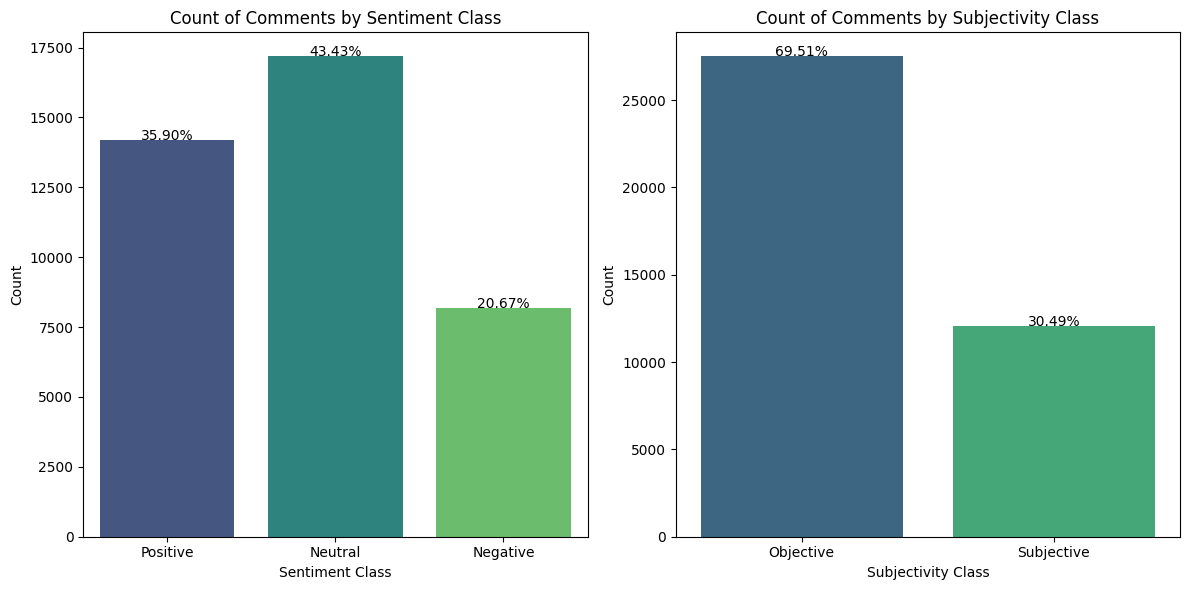

In [139]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot count of comments by sentiment class
sns.countplot(data=all_comments_df, x='sentiment_class', ax=axes[0], palette='viridis')
axes[0].set_title('Count of Comments by Sentiment Class')
axes[0].set_xlabel('Sentiment Class')
axes[0].set_ylabel('Count')

# Add proportion on top of each bar for sentiment class
total = len(all_comments_df)
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height + 0.1, '{:.2f}%'.format((height / total) * 100), ha="center")

# Plot count of comments by subjectivity
sns.countplot(data=all_comments_df, x='subjectivity_class', ax=axes[1], palette='viridis')
axes[1].set_title('Count of Comments by Subjectivity Class')
axes[1].set_xlabel('Subjectivity Class')
axes[1].set_ylabel('Count')

# Add proportion on top of each bar for subjectivity
total = len(all_comments_df)
for p in axes[1].patches:
    height = p.get_height()
    axes[1].text(p.get_x() + p.get_width() / 2., height + 0.1, '{:.2f}%'.format((height / total) * 100), ha="center")

plt.tight_layout()
plt.show()


### Contingency Table for sentiment and subjectivity classes.

In [140]:
contingency_table = pd.crosstab(index=all_comments_df['sentiment_class'], columns=all_comments_df['subjectivity_class'], margins=True)

print(contingency_table)

subjectivity_class  Objective  Subjective    All
sentiment_class                                 
Negative                 3506        4672   8178
Neutral                 16601         584  17185
Positive                 7394        6809  14203
All                     27501       12065  39566


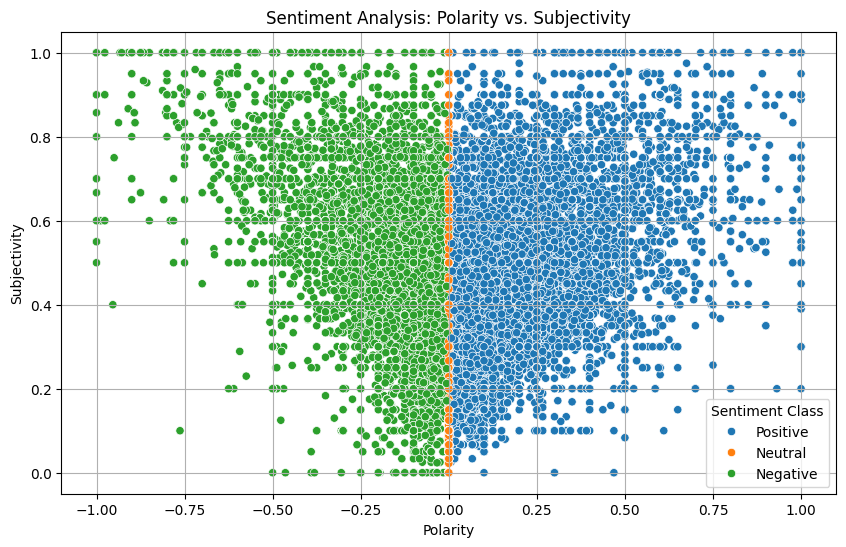

In [141]:
# I also create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_comments_df, x='polarity', y='subjectivity', hue='sentiment_class')
plt.title('Sentiment Analysis: Polarity vs. Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.legend(title='Sentiment Class')
plt.grid(True)
plt.show()


### Based on the sentiment analysis performed on the comments from videos related to 'Donald Trump elections 2024', I can say that:

* ### Negative Sentiment: The majority of comments with negative sentiment are subjective, accounting for 57% of all negative sentiment comments.
* ### Neutral Sentiment: Most comments with neutral sentiment are objective, constituting around 97% of all neutral sentiment comments.
* ### Positive Sentiment: In the case of positive sentiment, subjective comments represent approximately 48% of all positive sentiment comments. Objective comments account for the remaining 52%.